# Transformer-CRF Fusion Models

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer
from torchcrf import CRF

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm

In [5]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
# device='cpu'
print(device)

cuda


In [6]:
# Model evaluation
from transformers import EvalPrediction
from seqeval.metrics import accuracy_score, precision_score, recall_score, f1_score

In [7]:
from prepare_dataset import prepare_data

In [45]:
# training constants
MODEL_NAME = 'bert-base-uncased' # let's try bert first
MAX_LEN = 128
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 8
EPOCHS = 3
LEARNING_RATE = 1e-05
MAX_GRAD_NORM = 10

## Data Loader

In [9]:
class dataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, index):
        sentence = self.data.sentence[index]
        word_labels = self.data.tags[index]

        encoding = self.tokenizer(sentence,
                                  is_split_into_words=True,
                                  padding='max_length',
                                  truncation=True,
                                  max_length=self.max_len)

        labels = [labels_to_ids[label] for label in word_labels]

        encoded_labels = np.ones(len(encoding["input_ids"]), dtype=int) * -100
        label_mask = np.zeros(len(encoding["input_ids"]), dtype=bool)
        word_ids = encoding.word_ids()

        previous_word_idx = None
        for idx, word_idx in enumerate(word_ids):
            if word_idx is None:
                continue
            elif word_idx != previous_word_idx:
                encoded_labels[idx] = labels[word_idx]
                label_mask[idx] = True  # mark this token as valid
                previous_word_idx = word_idx

        item = {key: torch.tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.tensor(encoded_labels)
        label_mask[0] = True # force it starts with "on"
        item['label_mask'] = torch.tensor(label_mask)

        return item

    def __len__(self):
        return self.len

In [10]:
data_dict = prepare_data("../processed_notes.csv")
data = data_dict["data"]
labels_to_ids = data_dict["labels_to_ids"]
ids_to_labels = data_dict["ids_to_labels"]

In [11]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
NUM_LABELS = len(labels_to_ids)

In [12]:
train_size = 0.8
train_dataset = data.sample(frac=train_size,random_state=200)
test_dataset = data.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

print("FULL Dataset: {}".format(data.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = dataset(train_dataset, tokenizer, MAX_LEN)
testing_set = dataset(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (20305, 4)
TRAIN Dataset: (16244, 4)
TEST Dataset: (4061, 4)


In [46]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [14]:
labels_to_ids

{'O': 0,
 'B-DISO': 1,
 'I-DISO': 2,
 'B-PROC': 3,
 'I-PROC': 4,
 'B-ANAT': 5,
 'I-ANAT': 6,
 'B-UNK': 7,
 'B-ACTI': 8,
 'I-ACTI': 9,
 'B-PHYS': 10,
 'I-PHYS': 11,
 'B-PHEN': 12,
 'I-PHEN': 13,
 'B-CONC': 14,
 'B-CHEM': 15,
 'I-CONC': 16,
 'B-OBJC': 17,
 'I-UNK': 18,
 'B-DEVI': 19,
 'I-DEVI': 20,
 'B-LIVB': 21,
 'I-LIVB': 22}

## Model Construction

In [47]:
class BERT_CRF(nn.Module):
    def __init__(self, bert_model_name, num_labels):
        super(BERT_CRF, self).__init__()
        self.bert = AutoModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(0.1)
        self.hidden2tag = nn.Linear(self.bert.config.hidden_size, num_labels)
        self.crf = CRF(num_labels, batch_first=True)

    def forward(self, input_ids, attention_mask, labels=None, label_mask=None):
        emissions = self.bert(input_ids=input_ids,
                              attention_mask=attention_mask)[0]
        emissions = self.dropout(emissions)
        emissions = self.hidden2tag(emissions)

        if labels is not None:
            labels = labels.clone()
            labels[labels == -100] = 0  # CRF will ignore these via label_mask
            loss = -self.crf(emissions, labels, mask=label_mask.bool(), reduction='mean')
            predictions = self.crf.decode(emissions, mask=label_mask.bool())
            return loss, predictions
        else:
            predictions = self.crf.decode(emissions, mask=label_mask.bool())
            return predictions


In [48]:
# Sanity Check
model = BERT_CRF(MODEL_NAME, num_labels=NUM_LABELS).to(device)
inputs = training_set[2]
input_ids = inputs["input_ids"].unsqueeze(0).to(device)
attention_mask = inputs["attention_mask"].unsqueeze(0).to(device)
labels = inputs["labels"].unsqueeze(0).to(device)
label_mask = inputs["label_mask"].unsqueeze(0).to(device)

input_ids = input_ids.to(device)
attention_mask = attention_mask.to(device)
labels = labels.to(device)

outputs = model(input_ids, attention_mask=attention_mask, labels=labels, label_mask=label_mask)
initial_loss = outputs[0]
initial_loss

tensor(29.9997, device='cuda:0', grad_fn=<NegBackward0>)

In [49]:
# Initialization
model = BERT_CRF(MODEL_NAME, num_labels=NUM_LABELS).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)

In [92]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate(model, eval_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in eval_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            label_mask = batch["label_mask"].to(device)

            predictions = model(input_ids, attention_mask, labels=None, label_mask=label_mask)

            for pred_seq, label_seq, mask_seq in zip(predictions, labels, label_mask):
                label_seq = label_seq.cpu().numpy()
                mask_seq = mask_seq.cpu().numpy().astype(bool)
                mask_seq[0] = False

                # Extract only masked tokens
                true_label_ids = label_seq[mask_seq]
                pred_label_ids = pred_seq[:len(true_label_ids)]  # CRF may return exactly this many

                # Sanity check
                assert len(true_label_ids) == len(pred_label_ids), \
                    f"Mismatch in pred/true lengths: {len(pred_label_ids)} vs {len(true_label_ids)}"

                # Map to label strings
                all_preds += [ids_to_labels[p] for p in pred_label_ids]
                all_labels += [ids_to_labels[l] for l in true_label_ids]

    metrics = {
        "accuracy": accuracy_score(all_labels, all_preds),
        "precision": precision_score(all_labels, all_preds, average='macro'),
        "recall": recall_score(all_labels, all_preds, average='macro'),
        "f1": f1_score(all_labels, all_preds, average='macro'),
        "f1_all": f1_score(all_labels, all_preds, average=None),
    }
    return metrics

In [93]:
log_every = 200   # log every 50 batches
eval_every = 200 # evaluate every 200 batches
num_epochs = EPOCHS
log_history = []  # To store logged metrics
global_step = 0

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0.0
    num_batches = len(training_loader)
    
    for step, batch in enumerate(tqdm.tqdm(training_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        label_mask = batch['label_mask'].to(device)

        loss, _ = model(input_ids, attention_mask, labels, label_mask=label_mask)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        global_step += 1

        # Log training loss every 'log_every' steps
        if (step + 1) % log_every == 0:
            avg_loss = epoch_loss / (step + 1)
            log_history.append({
                "step": global_step,
                "loss": avg_loss
            })
            print(f"Step {global_step}: Avg Train Loss = {avg_loss:.4f}")

        # Run evaluation every 'eval_every' steps
        if (step + 1) % eval_every == 0:
            eval_metrics = evaluate(model, testing_loader, device)
            log_history.append({
                "step": global_step,
                "eval_f1": eval_metrics["f1"],
                "eval_accuracy": eval_metrics["accuracy"],
                "eval_precision": eval_metrics["precision"],
                "eval_recall": eval_metrics["recall"],
                "eval_loss": eval_metrics.get("eval_loss", None)  # if you compute eval loss
            })
            print(f"Step {global_step}: F1 = {eval_metrics['f1']:.4f}, Acc = {eval_metrics['accuracy']:.4f}, Prec = {eval_metrics['precision']:.4f}, Recall = {eval_metrics['recall']:.4f}")

    # End-of-epoch logging
    avg_epoch_loss = epoch_loss / num_batches
    print(f"Epoch {epoch+1} Completed: Avg Training Loss = {avg_epoch_loss:.4f}")
    eval_metrics = evaluate(model, testing_loader, device)
    print(f"Final: F1 = {eval_metrics['f1']:.4f}, Acc = {eval_metrics['accuracy']:.4f}, Prec = {eval_metrics['precision']:.4f}, Recall = {eval_metrics['recall']:.4f}")
    print(eval_metrics["f1_all"])


Epoch 1/3:  20%|█▉        | 199/1016 [00:36<02:29,  5.46it/s]

Step 200: Avg Train Loss = 0.2079


Epoch 1/3:  20%|█▉        | 201/1016 [00:50<42:16,  3.11s/it]

Step 200: F1 = 0.0992, Acc = 0.6820, Prec = 0.1031, Recall = 0.0980


Epoch 1/3:  39%|███▉      | 399/1016 [01:26<01:51,  5.55it/s]

Step 400: Avg Train Loss = 0.0951


/home/xc392/.conda/envs/clinical-ner/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Epoch 1/3:  39%|███▉      | 401/1016 [01:41<31:48,  3.10s/it]

Step 400: F1 = 0.0980, Acc = 0.6875, Prec = 0.1061, Recall = 0.0946


Epoch 1/3:  59%|█████▉    | 599/1016 [02:17<01:15,  5.50it/s]

Step 600: Avg Train Loss = 0.0555


/home/xc392/.conda/envs/clinical-ner/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Epoch 1/3:  59%|█████▉    | 601/1016 [02:31<21:31,  3.11s/it]

Step 600: F1 = 0.0973, Acc = 0.6891, Prec = 0.1012, Recall = 0.0951


Epoch 1/3:  78%|███████▊  | 792/1016 [03:06<00:52,  4.26it/s]


KeyboardInterrupt: 

In [83]:
def plot_eval():
    train_steps, train_loss = [], []
    eval_steps, eval_loss, f1s = [], [], []
    
    for entry in log_history:
        if "loss" in entry and "step" in entry:
            train_steps.append(entry["step"])
            train_loss.append(entry["loss"])
        if "eval_f1" in entry:
            eval_steps.append(entry["step"])
            eval_loss.append(entry.get("eval_loss", 0))  # or None if not computed
            f1s.append(entry["eval_f1"])
    
    plt.figure(figsize=(12, 5))
    
    # Plot losses
    plt.subplot(1, 2, 1)
    if train_loss:
        plt.plot(train_steps, train_loss, label="Train Loss")
    if eval_loss:
        plt.plot(eval_steps, eval_loss, label="Eval Loss")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.legend()
    
    # Plot F1
    plt.subplot(1, 2, 2)
    if f1s[0] is not None:
        plt.plot(eval_steps, f1s, label="Eval F1", color='green')
        plt.xlabel("Steps")
        plt.ylabel("F1 Score")
        plt.title("Evaluation F1 over Time")
        plt.legend()
    
    plt.tight_layout()

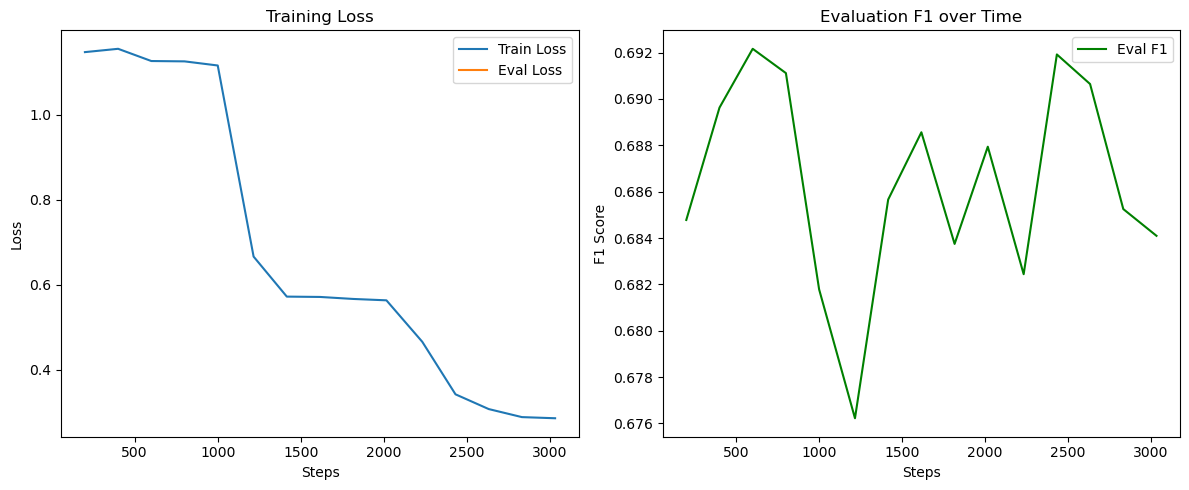

In [86]:
plot_eval()